# Data Cleaning and Modeling
## Project: Predicting NFL Outcomes Using Machine Learning
## Author: Nicholas Romano
## DS450-01 
## Data Science Senior Capstone
----

### Importing Libraries and Dataset

#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

#### Importing Dataset

In [2]:
df = pd.read_csv("EDA_Expanded_NFL_Data.csv")

### Data Cleaning

#### Dropping Tied Games From The Dataset

**`valueData(column)` function**

The `valueData` function takes a column of a dataframe, retrieves the data count and data frequencies of the values within the column passed within the parameter list. Then the function combines the count and frequency dataframes into a single dataframe, updates the column names and returns the dataframe containing both the count and frequency dataframe.

The `valueData` function is used in this notebook mainly to check the game results before and after modifying the column. This allows to see if the desired result (removing tied games) occured successfully.

In [3]:
def valueData(column):
    counts = df[column].value_counts()  #Retrieving Count Data
    frequencies = df[column].value_counts(normalize = True) #Retrieving Frequencies
    value_df = pd.concat([counts, frequencies], axis = 1) #Combining the two tables into one 
    value_df.rename(columns = {"count": "Total Instances Occured", "proportion": "Porportion of Total"}, inplace = True) #Renaming the columns for readability
    return value_df

One thing that I noticed while doing the EDA is that there are a few games that ended in a tie (14), but makes up a small proportion of the overall dataset (just above 0.2%) I elected to drop the tied games. Using the `valueData` function, we get the count of tied games at 14, compared to the 5613 games that resulting in one of the two teams (home/away) winning.

In [4]:
valueData('game_result')

,Total Instances Occured,Porportion of Total
game_result,,
1,3180,0.563730
0,2447,0.433788
2,14,0.002482


The following block of code drops the the ties from the dataset. It does it by retrieving the 14 index positions where there is a 2 in the game_result column, which represents a tied games. Then these rows at the correpsonding index valies are dropped, and the index values are reset to account for the dropping of the 14 tied games. Then the `valueData` function is used once again to see the new `game_result` values after dropping the ties.

In [5]:
#Getting a list of all the index values that represent a game that ended in a tie
tied_games = df[df["game_result"] == 2].index.to_list()

#Dropping the index values that represent a game that ended in a tie
df.drop(tied_games, inplace = True)

#Reseting index to accomadate for the dropped rows.
df.reset_index(drop = True, inplace = True)

#Redisplaying the game_result values to check and see if the ties did in fact get dropped
valueData('game_result')

,Total Instances Occured,Porportion of Total
game_result,,
1,3180,0.565132
0,2447,0.434868


---
#### Dropping Postseason Games From the Dataset

**Postseason Games**  
Another thing noticed in the EDA was the presence of Postseason games in the dataset. The concerning aspect about the presence of NFL postseason games are the fact that teams who regularly reach and make deep runs in the playoffs over the past 20 seaons (like the Patriots) will have more games played in comparison to teams that regularly miss reaching the playoffs. In creating the model based on this data, it would make sense to try and make every team play a similar amount of games. In that regard, dropping postseason games is one avenue to go down since all teams play the same number of regular season games.  

The following block of code creates two dataframes one for the number of home games played and one for the number of away games played, then concatenates both dataframes into one dataframe. Finally the combined dataframe is sorted in descending order in terms of the number of games played from most to least. As you can see in the output from block of code below, the range between the Patriots and Lions is 38 games. Removing the postseason games will shrink the differences in the number of games played from team to team.

In [6]:
#Number of Home Games for each NFL Team
homeGames = pd.DataFrame(df.home.groupby(df.home).count())

#Number of Away Games for each NFL Team
awayGames = pd.DataFrame(df.away.groupby(df.away).count())

#Combining the Home and Away Game Counts
gamesPlayed = pd.concat([homeGames, awayGames], axis = 1)

#Adding a 'total_games_played' column, which is the sum of the home and away game columns
gamesPlayed["total_games_played"] = gamesPlayed.sum(axis = 1)

#Sorting the 'total_games_played' column from greatest to least.
gamesPlayed.sort_values(['total_games_played'], ascending = False)

,home,away,total_games_played
Patriots,196,181,377
Seahawks,182,183,365
Colts,181,182,363
Packers,182,181,363
Eagles,184,177,361
Ravens,175,185,360
Chiefs,185,175,360
Steelers,179,180,359
49ers,177,179,356
Saints,179,176,355


**Postseason Games Solution**  
To solve the problem of the differing amount of games played due to postseason games played, manually scraped data of the dates of the postseason games during the seasons included in the dataset. The data was retreieved manually from the ESPN's `NFL Schedule` tab and going through the needed seasons then recording the date of first postseason game and the superbowl. The date of the first postseason game is the first string in the list and the data of the Superbowl is the second string in the list. The link to the page that I retrieved the data is provided here: <a href= "https://www.espn.com/nfl/schedule/_/week/5/year/2022/seasontype/3">ESPN NFL Schedule Webpage</a> .

To got about dropping the postseason games:
- The `postSeasonGames(startingDate, endingDate)` function was created to retrieve the games that occured in each of the seasons postseasons based on the dates retrieved from ESPN.
- The `postSeasonDates` dictionary stores a key-value pair consisting of the NFL season, the date of the first NFL postseason game of that season, and the Superbowl of that year. The key is the year that the NFL regular season started in - so the first key is 2002 representing the 2002-2003 season and the second key is the 2003-2004 season - and the values are a list of two values representing the start and end of the postseason of the given NFL Season.
- Then by creating a list named `postSeasonGamesList` and looping through the keys of `postSeasonDates` dictionary, I was able to retrieve the index values of all the postseason games and store the values in the `postSeasonGamesList`, which would be used to eventually drop the rows corresponding to the index values within the list.

**`postSeasonGames` function: retrieves index values of postseason games within the dataset**

In [7]:
def postSeasonGames(startingDate, endingDate):
    return df.loc[(startingDate <= df.date) & (df.date <= endingDate)].index.values.tolist()

**Creation of the `postSeasonDates` dictionary to retrieve postseason game index values and storing them in the postSeasonGamesList**

In [8]:
#Converting df.date to datetime
df.date = pd.to_datetime(df.date)

#Creating the postSeasonDates dictionary (season: ["Date of First Postseason Game of Season", "Date of Superbowl that Season])
postSeasonDates = {2002: ["2003-01-04", "2003-01-26"],
                   2003: ["2004-01-03", "2004-02-01"],
                   2004: ["2005-01-08", "2005-02-06"],
                   2005: ["2006-01-07", "2006-02-05"],
                   2006: ["2007-01-06", "2007-02-04"],
                   2007: ["2008-01-05", "2008-02-03"],
                   2008: ["2009-01-03", "2009-02-01"],
                   2009: ["2010-01-09", "2010-02-07"],
                   2010: ["2011-01-08", "2011-02-06"],
                   2011: ["2012-01-07", "2012-02-05"],
                   2012: ["2013-01-05", "2013-02-03"],
                   2013: ["2014-01-04", "2014-02-02"],
                   2014: ["2015-01-03", "2015-02-01"],
                   2015: ["2016-01-09", "2016-02-07"],
                   2016: ["2017-01-07", "2017-02-05"],
                   2017: ["2018-01-06", "2018-02-04"],
                   2018: ["2019-01-05", "2019-02-03"],
                   2019: ["2020-01-04", "2020-02-02"],
                   2020: ["2021-01-09", "2021-02-07"],
                   2021: ["2022-01-15", "2022-02-13"],
                   2022: ["2023-01-14", "2023-02-12"]}

#postSeasonGamesList to store all postseason games index values
postSeasonGamesList = []

#Iterating through each season, retrieving the index postions between the start and ending date of that seasons playoffs
#then adding those values to the postSeasonGamesList
for season in postSeasonDates.keys():
    individualYearPostSeasonList = list()
    individualYearPostSeasonList = postSeasonGames(postSeasonDates.get(season)[0], postSeasonDates.get(season)[1])

    for date in individualYearPostSeasonList:
        postSeasonGamesList.append(date)

**Dropping of the Postseason Games in Dataset**  
The number of postseason games within the dataset is 237, which represents just above 4% of the total games within the dataset. So, the number of postseason games is relatively small in comparison to the total number of games included. Therefore, it appears reasonable to drop these to create a balance among the number of games each team playes

In [9]:
print(f"Number of Postseason Games in the Dataset: {len(postSeasonGamesList)}")
print(f"Total Number of Games in the Dataset: {len(df)}")
print(f"Percentage of Games That Are Postseason Games: {(len(postSeasonGamesList)/len(df))* 100}%")

Number of Postseason Games in the Dataset: 237
Total Number of Games in the Dataset: 5627
Percentage of Games That Are Postseason Games: 4.2118357917185%


In [10]:
#Dropping the postseason games from the dataframe and resetting the index to take into account the missing rows.
df.drop(postSeasonGamesList, inplace=True)
df.reset_index(drop=True, inplace=True)

**Updated Game Count for each team**  
After dropping ties and postseason games, it appears that the NFL teams are more equally represeting in the number of games that they played in comparison to before dropping these games.

In [11]:
#Creating a dataframe that contains the number of home games for each team
homeGames = pd.DataFrame(df.home.groupby(df.home).count())

#Creating a dataframe that contains the number of away games for each team
awayGames = pd.DataFrame(df.away.groupby(df.away).count())

#Combining the home and away game numbers for each team, summing the total games played, and sorting in descending order
gamesPlayed = pd.concat([homeGames, awayGames], axis = 1)
gamesPlayed["total_games_played"] = gamesPlayed.sum(axis = 1)
gamesPlayed.sort_values(['total_games_played'], ascending = False)

,home,away,total_games_played
Bears,169,169,338
Titans,169,169,338
Broncos,169,169,338
Saints,169,169,338
Ravens,169,169,338
Chargers,169,169,338
Chiefs,169,169,338
Raiders,169,169,338
Patriots,169,169,338
Dolphins,169,169,338


---
#### Getting Dataframes for each NFL Team

The overall goal was to build off of the future reasearch proposition of Matt Gifford and Tuncay Bayrak's article in *Decision Analytics Journal* titled “A predictive analytics model for forecasting outcomes in the National Football League games using decision tree and logistic regression.” in trying to use recent prior performances to predict the result of upcoming games. With that goal in mind, my approach was to get the average statistics of recent games from each team entering a given game to see if I could accurately predict the outcome of the game. 

Setting up to do this, entails:
- Getting 1 dataframe for each individual NFL team consisting of the games that they played (regardless of whether the games was home or away)
- Transforming the dataframes for each individual NFL team so that each row is an average of the previous *n* games played
- Combining the transformed dataframes back into one overall dataframe

##### Getting individual NFL Team Dataframes

The `teamDataFrame` function was created in expediating the process of retrieving the away and home game data for each NFL team and combining it into a single Dataframe with just the games that a specific team played. It first retrieves the away games, then retrieves a rearranged home game dataframe the columns match those of the away gmae dataframe, then concatenates the two dataframs, and finally sorts the dataframe by data so the games are arranged in the order they were played.

In [12]:
def teamDataFrame(teamName):
    #Querying the games in which the specific team was the away team
    awayDF = df.query(f"away == '{teamName}'")

    #A list of the renamed columns, so that when the away game and home game dataframes are combined both will share the same columns
    renamedColumns = ['date', 
                      'away', 
                      'home',
                      'offensive_first_downs',
                      'offensive_third_down_conversions', 
                      'offensive_third_down_opportunities',
                      'offensive_fourth_down_conversions', 
                      'offensive_fourth_down_conversion_attempts',
                      'offensive_passing_completions', 
                      'offensive_passing_attempts',
                      'offensive_passing_yards', 
                      'offensive_rushing_attempts', 
                      'offensive_rushing_yards',
                      'offensive_total_yards', 
                      'offensive_sacks_taken', 
                      'offensive_yards_lost_from_sacks',
                      'offensive_fumbles', 
                      'offensive_interceptions', 
                      'offensive_turnovers', 
                      'offensive_penalties',
                      'offensive_penalty_yards', 
                      'offensive_redzone_conversions',
                      'offensive_redzone_drives', 
                      'team_def_st_td', 
                      'offensive_drives',
                      'team_offensive_time_of_possession', 
                      'defensive_first_downs_allowed', 
                      'defensive_third_down_conversions_allowed',
                      'defensive_third_down_opportunities', 
                      'defensive_fourth_down_conversions_allowed',
                      'defensive_fourth_down_conversion_attempts', 
                      'defensive_passing_completions',
                      'defensive_passing_attempts', 
                      'defensive_passing_yards_allowed', 
                      'defensive_rushing_attempts',
                      'defensive_rushing_yards_allowed', 
                      'defensive_total_yards_allowed', 
                      'defensive_sacks',
                      'defensive_sack_yards', 
                      'defensive_fumbles_forced', 
                      'defensive_int_forced', 
                      'defensive_turnovers_forced',
                      'opposing_team_team_penalties', 
                      'opposing_team_penalty_yards', 
                      'defensive_redzone_conversions',
                      'defensive_redzone_opportunities', 
                      'opposing_team_def_st_td', 
                      'opposing_team_drives',
                      'opposing_team_possession',
                      'points_scored', 
                      'points_allowed', 
                      'game_result']

    #Renaming the columns within awayDF to be that of those in the renamedColumns list
    awayDF.columns = renamedColumns

    #Querying the home games for specific team. This dataframe is rearranged to match that of the awayDF.
    #awayDF has the indivial team stats then opposing team stats after, since that is how it was in the original df
    homeDF = df.query(f"home == '{teamName}'")[['date', 
                                                'away', 
                                                'home', 
                                                'first_downs_home', 
                                                'third_down_conversions_home',
                                                'third_down_opportunities_home', 
                                                'fourth_down_conversions_home',
                                                'fourth_down_conversion_attempts_home', 
                                                'passing_completions_home',
                                                'passing_attempts_home', 
                                                'passing_yards_home', 
                                                'rushing_attempts_home',
                                                'rushing_yards_home', 
                                                'total_yards_home', 
                                                'times_sacked_home',
                                                'sack_yards_lost_home', 
                                                'fumbles_home', 
                                                'int_home', 
                                                'turnovers_home',
                                                'team_penalties_home', 
                                                'penalty_yards_home', 
                                                'redzone_conversions_home',
                                                'redzone_opportunities_home', 
                                                'def_st_td_home', 
                                                'drives_home',
                                                'possession_home', 
                                                'first_downs_away',
                                                'third_down_conversions_away', 
                                                'third_down_opportunities_away',
                                                'fourth_down_conversions_away', 
                                                'fourth_down_conversion_attempts_away',
                                                'passing_completions_away', 
                                                'passing_attempts_away',
                                                'passing_yards_away', 
                                                'rushing_attempts_away', 
                                                'rushing_yards_away',
                                                'total_yards_away', 
                                                'times_sacked_away', 
                                                'sack_yards_lost_away',
                                                'fumbles_away', 
                                                'int_away', 
                                                'turnovers_away', 
                                                'team_penalties_away',
                                                'penalty_yards_away', 
                                                'redzone_conversions_away',
                                                'redzone_opportunities_away', 
                                                'def_st_td_away', 
                                                'drives_away',
                                                'possession_away', 
                                                'score_away', 
                                                'score_home', 
                                                'game_result']]
    
    #Renaming the columns to those in the renamedColumns list
    homeDF.columns = renamedColumns

    #Concatinging both the awayDF and homeDF
    teamDF = pd.concat([awayDF, homeDF])

    #Sorting the teamDF by date so the games are in order from when they occured.
    teamDF.sort_values(by = ["date"], ascending = True, inplace = True)
    
    return teamDF

The `teamRollingAverages` function expediates the process of generating the average statistics of a teams pervious number of games. The function takes in a TeamDataFrame, the number of games to include in the averaging of statistics, and the teamName. The function takes the average of the numerical statistics of the specificed number games in the parameter list, if the number of previous games is less than the specified numnber of games (so, 3, 2, and 1) it still takes the average of the previous past games, but it would just include fewer games. Then the function shifts the averages down one row since the rolling method includes the row in the calculations and the goal is to include previous game data, so the `.shift(periods = 1)` takes care of that. Finally, the team score, opponent score, and game result are added to the end of the columns, and the date, team, opponent are added to the beginning of the columns. *Note: the opponent is added using the `opponent()` function.*

In [13]:
def teamRollingAverages(TeamDataFrame, RollingAVG_Period, teamName):
    #Calculates rolling averages of the specified number of periods in the parameter list (RollingAVG_Period)
    teamAvg_df = TeamDataFrame[['offensive_first_downs', 'offensive_third_down_conversions', 'offensive_third_down_opportunities',
                                'offensive_fourth_down_conversions', 'offensive_fourth_down_conversion_attempts',
                                'offensive_passing_completions', 'offensive_passing_attempts', 'offensive_passing_yards', 
                                'offensive_rushing_attempts', 'offensive_rushing_yards', 'offensive_total_yards', 
                                'offensive_sacks_taken', 'offensive_yards_lost_from_sacks', 
                                'offensive_fumbles', 'offensive_interceptions', 'offensive_turnovers', 'offensive_penalties','offensive_penalty_yards', 
                                'offensive_redzone_conversions','offensive_redzone_drives', 'team_def_st_td', 'offensive_drives','team_offensive_time_of_possession', 
                                'defensive_first_downs_allowed', 'defensive_third_down_conversions_allowed','defensive_third_down_opportunities', 
                                'defensive_fourth_down_conversions_allowed','defensive_fourth_down_conversion_attempts', 
                                'defensive_passing_completions','defensive_passing_attempts', 'defensive_passing_yards_allowed', 
                                'defensive_rushing_attempts','defensive_rushing_yards_allowed', 'defensive_total_yards_allowed', 
                                'defensive_sacks','defensive_sack_yards', 'defensive_fumbles_forced', 'defensive_int_forced', 'defensive_turnovers_forced',
                                'opposing_team_team_penalties', 'opposing_team_penalty_yards', 
                                'defensive_redzone_conversions','defensive_redzone_opportunities', 
                                'opposing_team_def_st_td', 'opposing_team_drives','opposing_team_possession',
                                'points_scored', 'points_allowed']].rolling(RollingAVG_Period, min_periods = 1).mean().shift(periods = 1)

    #Entering the scores, date, team, and opponent columns to the teamAVG_df. They are the same as the teamDF, except for the opponent column
    #The opponent function takes care the oppent column
    teamAvg_df.insert(48, 'team_score', -1)
    teamAvg_df.team_score = TeamDataFrame.points_scored
    teamAvg_df.insert(49, 'opponent_score', -1)
    teamAvg_df.opponent_score = TeamDataFrame.points_allowed
    teamAvg_df.insert(50, 'game_result', -1)
    teamAvg_df.game_result = TeamDataFrame.game_result
    teamAvg_df.insert(0, 'opponent', "")
    teamAvg_df.insert(0, 'team', f'{teamName}')
    teamAvg_df.insert(0, 'date', 0)
    teamAvg_df.date = TeamDataFrame.date
    

    return teamAvg_df
    

The `opponent` function fills in the opponent in the teamAvgDataframe. It does this by looping throught the team average statistics dataframe index and retrieving the opponent by retrieving the opponent in the nonAverage team statistic dataframe.

In [14]:
def opponent(teamDataframe, teamAvgDataFrame, teamName):
    
    for gameIndex in teamAvgDataFrame.index.tolist():
        
        #If the home team is the team whose dataframe oppondent column is being modified, the value in the opponent column for the teamAVG dataframe
        #is set to the away team in the nonAvg team dataframe
        if (teamDataframe.loc[gameIndex, 'home'] == teamName):
            teamAvgDataFrame.loc[gameIndex, 'opponent'] = teamDataframe.loc[gameIndex, 'away']

        #Otherwise the the value in the opponent column for the teamAVG dataframe
        #is set to the home team in the nonAvg team dataframe
        else:
            teamAvgDataFrame.loc[gameIndex, 'opponent'] = teamDataframe.loc[gameIndex, 'home']


Using the `teamDataFrame`, `teamRollingAverages`, and `opponent` functions to create the individual team and individual team average statistic dataframes for the 32 NFL teams. The dataframe names are the location name of the specific NFL team (for example: the San Francisco 49ers dataframes are named SanFrancisco and SanFranciscoAVG respectfully). For the LA Chargers, LA Rams, NY Jets, and NY Gaints, the name for these team dataframes have both the team location and team names since these teams share team location name.

The team and team average dataframes are converted and saved as a `.csv` file. 

In [15]:
#Team DataFrame: San Fransisco 49ers
SanFrancisco = teamDataFrame('49ers')
SanFranciscoAVG = teamRollingAverages(SanFrancisco, 4, '49ers')
opponent(SanFrancisco, SanFranciscoAVG, '49ers')
SanFrancisco.to_csv("SanFrancisco.csv", index = False)
SanFranciscoAVG.to_csv("SanFranciscoAVG.csv", index = False)

#Team DataFrame: New York Jets
NewYork_Jets = teamDataFrame('Jets')
NewYork_JetsAVG = teamRollingAverages(NewYork_Jets, 4, 'Jets')
opponent(NewYork_Jets, NewYork_JetsAVG, 'Jets')
NewYork_Jets.to_csv("NewYork_Jets.csv", index = False)
NewYork_JetsAVG.to_csv("NewYork_JetsAVG.csv", index = False)

#Team DataFrame: Minnesota Vikings
Minnesota = teamDataFrame('Vikings')
MinnesotaAVG = teamRollingAverages(Minnesota, 4, 'Vikings')
opponent(Minnesota, MinnesotaAVG, 'Vikings')
Minnesota.to_csv("Minnesota.csv", index = False)
MinnesotaAVG.to_csv("MinnesotaAVG.csv", index = False)

#Team DataFrame: Los Angeles Chargers
LosAngeles_Chargers = teamDataFrame('Chargers')
LosAngeles_ChargersAVG = teamRollingAverages(LosAngeles_Chargers, 4, 'Chargers')
opponent(LosAngeles_Chargers, LosAngeles_ChargersAVG, 'Chargers')
LosAngeles_Chargers.to_csv("LosAngeles_Chargers.csv", index = False)
LosAngeles_ChargersAVG.to_csv("LosAngeles_ChargersAVG.csv", index = False)

#Team DataFrame: Kansas City Chiefs
KansasCity = teamDataFrame('Chiefs')
KansasCityAVG = teamRollingAverages(KansasCity, 4, 'Chiefs')
opponent(KansasCity, KansasCityAVG, 'Chiefs')
KansasCity.to_csv("KansasCity.csv", index = False)
KansasCityAVG.to_csv("KansasCityAVG.csv", index = False)

#Team DataFrame: Atlanta Falcons
Atlanta = teamDataFrame('Falcons')
AtlantaAVG = teamRollingAverages(Atlanta, 4, 'Falcons')
opponent(Atlanta, AtlantaAVG, 'Falcons')
Atlanta.to_csv("Atlanta.csv", index = False)
AtlantaAVG.to_csv("AtlantaAVG.csv", index = False)

#Team DataFrame: Philadelphia Eagles
Philadelphia = teamDataFrame('Eagles')
PhiladelphiaAVG = teamRollingAverages(Philadelphia, 4, 'Eagles')
opponent(Philadelphia, PhiladelphiaAVG, 'Eagles')
Philadelphia.to_csv("Philadelphia.csv", index = False)
PhiladelphiaAVG.to_csv("PhiladelphiaAVG.csv", index = False)

#Team DataFrame: Detriot Lions
Detriot = teamDataFrame('Lions')
DetriotAVG = teamRollingAverages(Detriot, 4, 'Lions')
opponent(Detriot, DetriotAVG, 'Lions')
Detriot.to_csv("Detriot.csv", index = False)
DetriotAVG.to_csv("DetriotAVG.csv", index = False)

#Team DataFrame: Arizona Cardinals
Arizona = teamDataFrame('Cardinals')
ArizonaAVG = teamRollingAverages(Arizona, 4, 'Cardinals')
opponent(Arizona, ArizonaAVG, 'Cardinals')
Arizona.to_csv("Arizona.csv", index = False)
ArizonaAVG.to_csv("ArizonaAVG.csv", index = False)

#Team DataFrame: Baltimore Ravens
Baltimore = teamDataFrame('Ravens')
BaltimoreAVG = teamRollingAverages(Baltimore, 4, 'Ravens')
opponent(Baltimore, BaltimoreAVG, 'Ravens')
Baltimore.to_csv("Baltimore.csv", index = False)
BaltimoreAVG.to_csv("BaltimoreAVG.csv", index = False)

#Team DataFrame: Indianapolis Colts
Indianapolis = teamDataFrame('Colts')
IndianapolisAVG = teamRollingAverages(Indianapolis, 4, 'Colts')
opponent(Indianapolis, IndianapolisAVG, 'Colts')
Indianapolis.to_csv("Indianapolis.csv", index = False)
IndianapolisAVG.to_csv("IndianapolisAVG.csv", index = False)

#Team DataFrame: Los Angeles Rams
LosAngeles_Rams = teamDataFrame('Rams')
LosAngeles_RamsAVG = teamRollingAverages(LosAngeles_Rams, 4, 'Rams')
opponent(LosAngeles_Rams, LosAngeles_RamsAVG, 'Rams')
LosAngeles_Rams.to_csv("LosAngeles_Rams.csv", index = False)
LosAngeles_RamsAVG.to_csv("LosAngeles_RamsAVG.csv", index = False)

#Team DataFrame: Seattle Seahawks
Seattle = teamDataFrame('Seahawks')
SeattleAVG = teamRollingAverages(Seattle, 4, 'Seahawks')
opponent(Seattle, SeattleAVG, 'Seahawks')
Seattle.to_csv("Seattle.csv", index = False)
SeattleAVG.to_csv("SeattleAVG.csv", index = False)

#Team DataFrame: New Orleans Saints
NewOrleans = teamDataFrame('Saints')
NewOrleansAVG = teamRollingAverages(NewOrleans, 4, 'Saints')
opponent(NewOrleans, NewOrleansAVG, 'Saints')
NewOrleans.to_csv("NewOrleans.csv", index = False)
NewOrleansAVG.to_csv("NewOrleansAVG.csv", index = False)

#Team DataFrame: Dallas Cowboys
Dallas = teamDataFrame('Cowboys')
DallasAVG = teamRollingAverages(Dallas, 4, 'Cowboys')
opponent(Dallas, DallasAVG, 'Cowboys')
Dallas.to_csv("Dallas.csv", index = False)
DallasAVG.to_csv("DallasAVG.csv", index = False)

#Team DataFrame: Pittsburgh Steelers
Pittsburgh = teamDataFrame('Steelers')
PittsburghAVG = teamRollingAverages(Pittsburgh, 4, 'Steelers')
opponent(Pittsburgh, PittsburghAVG, 'Steelers')
Pittsburgh.to_csv("Pittsburgh.csv", index = False)
PittsburghAVG.to_csv("PittsburghAVG.csv", index = False)

#Team DataFrame: Chicago Bears
Chicago = teamDataFrame('Bears')
ChicagoAVG = teamRollingAverages(Chicago, 4, 'Bears')
opponent(Chicago, ChicagoAVG, 'Bears')
Chicago.to_csv("Chicago.csv", index = False)
ChicagoAVG.to_csv("ChicagoAVG.csv", index = False)

#Team DataFrame: Cincinnati Bengals
Cincinnati = teamDataFrame('Bengals')
CincinnatiAVG = teamRollingAverages(Cincinnati, 4, 'Bengals')
opponent(Cincinnati, CincinnatiAVG, 'Bengals')
Cincinnati.to_csv("Cincinnati.csv", index = False)
CincinnatiAVG.to_csv("CincinnatiAVG.csv", index = False)

#Team DataFrame: Tennessee Titans
Tennessee = teamDataFrame('Titans')
TennesseeAVG = teamRollingAverages(Tennessee, 4, 'Titans')
opponent(Tennessee, TennesseeAVG, 'Titans')
Tennessee.to_csv("Tennessee.csv", index = False)
TennesseeAVG.to_csv("TennesseeAVG.csv", index = False)

#Team DataFrame: Miami Dolphins
Miami = teamDataFrame('Dolphins')
MiamiAVG = teamRollingAverages(Miami, 4, 'Dolphins')
opponent(Miami, MiamiAVG, 'Dolphins')
Miami.to_csv("Miami.csv", index = False)
MiamiAVG.to_csv("MiamiAVG.csv", index = False)

#Team DataFrame: Jacksonville Jaquars
Jacksonville = teamDataFrame('Jaguars')
JacksonvilleAVG = teamRollingAverages(Jacksonville, 4, 'Jaguars')
opponent(Jacksonville, JacksonvilleAVG, 'Jaguars')
Jacksonville.to_csv("Jacksonville.csv", index = False)
JacksonvilleAVG.to_csv("JacksonvilleAVG.csv", index = False)

#Team DataFrame: GreenBay Packers
GreenBay = teamDataFrame('Packers')
GreenBayAVG = teamRollingAverages(GreenBay, 4, 'Packers')
opponent(GreenBay, GreenBayAVG, 'Packers')
GreenBay.to_csv("GreenBay.csv", index = False)
GreenBayAVG.to_csv("GreenBayAVG.csv", index = False)

#Team DataFrame: Buffalo Bills
Buffalo = teamDataFrame('Bills')
BuffaloAVG = teamRollingAverages(Buffalo, 4, 'Bills')
opponent(Buffalo, BuffaloAVG, 'Bills')
Buffalo.to_csv("Buffalo.csv", index = False)
BuffaloAVG.to_csv("BuffaloAVG.csv", index = False)

#Team DataFrame: Houston Texans
Houston = teamDataFrame('Texans')
HoustonAVG = teamRollingAverages(Houston, 4, 'Texans')
opponent(Houston, HoustonAVG, 'Texans')
Houston.to_csv("Houston.csv", index = False)
HoustonAVG.to_csv("HoustonAVG.csv", index = False)

#Team DataFrame: New England Patriots
NewEngland = teamDataFrame('Patriots')
NewEnglandAVG = teamRollingAverages(NewEngland, 4, 'Patriots')
opponent(NewEngland, NewEnglandAVG, 'Patriots')
NewEngland.to_csv("NewEngland.csv", index = False)
NewEnglandAVG.to_csv("NewEnglandAVG.csv", index = False)

#Team DataFrame: New York Giants
NewYork_Giants = teamDataFrame('Giants')
NewYork_GiantsAVG = teamRollingAverages(NewYork_Giants, 4, 'Giants')
opponent(NewYork_Giants, NewYork_GiantsAVG, 'Giants')
NewYork_Giants.to_csv("NewYork_Giants.csv", index = False)
NewYork_GiantsAVG.to_csv("NewYork_GiantsAVG.csv", index = False)

#Team DataFrame: Denver Broncos
Denver = teamDataFrame('Broncos')
DenverAVG = teamRollingAverages(Denver, 4, 'Broncos')
opponent(Denver, DenverAVG, 'Broncos')
Denver.to_csv("Denver.csv", index = False)
DenverAVG.to_csv("DenverAVG.csv", index = False)

#Team DataFrame: Las Vegas Raiders
LasVegas = teamDataFrame('Raiders')
LasVegasAVG = teamRollingAverages(LasVegas, 4, 'Raiders')
opponent(LasVegas, LasVegasAVG, 'Raiders')
LasVegas.to_csv("LasVegas.csv", index = False)
LasVegasAVG.to_csv("LasVegasAVG.csv", index = False)

#Team DataFrame: Clevand Browns
Cleveland = teamDataFrame('Browns')
ClevelandAVG = teamRollingAverages(Cleveland, 4, 'Browns')
opponent(Cleveland, ClevelandAVG, 'Browns')
Cleveland.to_csv("Cleveland.csv", index = False)
ClevelandAVG.to_csv("ClevelandAVG.csv", index = False)

#Team DataFrame: Carolina Panthers
Carolina = teamDataFrame('Panthers')
CarolinaAVG = teamRollingAverages(Carolina, 4, 'Panthers')
opponent(Carolina, CarolinaAVG, 'Panthers')
Carolina.to_csv("Carolina.csv", index = False)
CarolinaAVG.to_csv("CarolinaAVG.csv", index = False)

#Team DataFrame: Washington Commanders
Washington = teamDataFrame('Commanders')
WashingtonAVG = teamRollingAverages(Washington, 4, 'Commanders')
opponent(Washington, WashingtonAVG, 'Commanders')
Washington.to_csv("Washington.csv", index = False)
WashingtonAVG.to_csv("WashingtonAVG.csv", index = False)

#Team DataFrame: Tampa Bay Buccaneers
TampaBay = teamDataFrame('Buccaneers')
TampaBayAVG = teamRollingAverages(TampaBay, 4, 'Buccaneers')
opponent(TampaBay, TampaBayAVG, 'Buccaneers')
TampaBay.to_csv("TampaBay.csv", index = False)
TampaBayAVG.to_csv("TampaBayAVG.csv", index = False)

---
**Combining teamRollingAverage Dataframes**  
**Step 1: Keeping Needed Data from the overall dataframe.**  
Modifying the overall datafram to just contain the data, away team, home team, score_away, score_home, and game_result columns. The others columns are dropped since the team average columns for both the home and away team will be added to the dataframe. The new columsn are inserted using the `.insert()` method. The new columns are inserted with a `np.nan` value.

***Dropping unneeded columns***

In [16]:
df.drop(columns=['first_downs_away', 'third_down_conversions_away', 'third_down_opportunities_away', 'fourth_down_conversions_away', 
                 'fourth_down_conversion_attempts_away', 'passing_completions_away', 'passing_attempts_away', 'passing_yards_away', 
                 'rushing_attempts_away', 'rushing_yards_away','total_yards_away', 'times_sacked_away', 'sack_yards_lost_away',
                 'fumbles_away', 'int_away', 'turnovers_away', 'team_penalties_away', 'penalty_yards_away', 'redzone_conversions_away',
                 'redzone_opportunities_away', 'def_st_td_away', 'drives_away', 'possession_away', 'first_downs_home', 'third_down_conversions_home',
                 'third_down_opportunities_home', 'fourth_down_conversions_home', 'fourth_down_conversion_attempts_home', 'passing_completions_home',
                 'passing_attempts_home', 'passing_yards_home', 'rushing_attempts_home', 'rushing_yards_home', 'total_yards_home', 'times_sacked_home',
                 'sack_yards_lost_home', 'fumbles_home', 'int_home', 'turnovers_home', 'team_penalties_home', 'penalty_yards_home', 'redzone_conversions_home',
                 'redzone_opportunities_home', 'def_st_td_home', 'drives_home', 'possession_home'], inplace=True)

df

,date,away,home,score_away,score_home,game_result
0,2002-09-05,49ers,Giants,16,13,0
1,2002-09-08,Jets,Bills,37,31,0
2,2002-09-08,Vikings,Bears,23,27,1
3,2002-09-08,Chargers,Bengals,34,6,0
4,2002-09-08,Chiefs,Browns,40,39,0
...,...,...,...,...,...,...
5385,2023-01-08,Giants,Eagles,16,22,1
5386,2023-01-08,Cardinals,49ers,13,38,1
5387,2023-01-08,Rams,Seahawks,16,19,1
5388,2023-01-08,Cowboys,Commanders,6,26,1


***Inserting New Columns for team average data for both the home and away teams. Then filling in the columns with an np.nan value.***  
Inserting the columns to contain both the home and away teams average statistics for the past few games. The columns are filled with a np.nan value.

In [17]:
df.insert(6, 'offensive_first_downs_away', np.nan)
df.insert(7, 'offensive_third_down_conversions_away', np.nan)
df.insert(8, 'offensive_third_down_opportunities_away', np.nan)
df.insert(9, 'offensive_fourth_down_conversions_away', np.nan)
df.insert(10, 'offensive_fourth_down_conversion_attempts_away', np.nan)
df.insert(11, 'offensive_passing_completions_away', np.nan)
df.insert(12, 'offensive_passing_attempts_away', np.nan)
df.insert(13, 'offensive_passing_yards_away', np.nan)
df.insert(14, 'offensive_rushing_attempts_away', np.nan)
df.insert(15, 'offensive_rushing_yards_away', np.nan)
df.insert(16, 'offensive_total_yards_away', np.nan)
df.insert(17, 'offensive_sacks_taken_away', np.nan)
df.insert(18, 'offensive_yards_lost_from_sacks_away', np.nan)
df.insert(19, 'offensive_fumbles_away', np.nan)
df.insert(20, 'offensive_interceptions_away', np.nan)
df.insert(21, 'offensive_turnovers_away', np.nan)
df.insert(22, 'offensive_penalties_away', np.nan)
df.insert(23, 'offensive_penalty_yards_away', np.nan)
df.insert(24, 'offensive_redzone_conversions_away', np.nan)
df.insert(25, 'offensive_redzone_drives_away', np.nan)
df.insert(26, 'team_def_st_td_away', np.nan)
df.insert(27, 'offensive_drives_away', np.nan)
df.insert(28, 'team_offensive_time_of_possession_away', np.nan)
df.insert(29, 'defensive_first_downs_allowed_away', np.nan)
df.insert(30, 'defensive_third_down_conversions_allowed_away', np.nan)
df.insert(31, 'defensive_third_down_opportunities_away', np.nan)
df.insert(32, 'defensive_fourth_down_conversions_allowed_away', np.nan)
df.insert(33, 'defensive_fourth_down_conversion_attempts_away', np.nan)
df.insert(34, 'defensive_passing_completions_away', np.nan)
df.insert(35, 'defensive_passing_attempts_away', np.nan)
df.insert(36, 'defensive_passing_yards_allowed_away', np.nan)
df.insert(37, 'defensive_rushing_attempts_away', np.nan)
df.insert(38, 'defensive_rushing_yards_allowed_away', np.nan)
df.insert(39, 'defensive_total_yards_allowed_away', np.nan)
df.insert(40, 'defensive_sacks_away', np.nan)
df.insert(41, 'defensive_sack_yards_away', np.nan)
df.insert(42, 'defensive_fumbles_forced_away', np.nan)
df.insert(43, 'defensive_int_forced_away', np.nan)
df.insert(44, 'defensive_turnovers_forced_away', np.nan)
df.insert(45, 'opposing_team_team_penalties_away', np.nan)
df.insert(46, 'opposing_team_penalty_yards_away', np.nan)
df.insert(47, 'defensive_redzone_conversions_away', np.nan)
df.insert(48, 'defensive_redzone_opportunities_away', np.nan)
df.insert(49, 'opposing_team_def_st_td_away', np.nan)
df.insert(50, 'opposing_team_drives_away', np.nan)
df.insert(51, 'opposing_team_possession_away', np.nan)
df.insert(52, 'points_scored_away', np.nan)
df.insert(53, 'points_allowed_away', np.nan)

df.insert(54, 'offensive_first_downs_home', np.nan)
df.insert(55, 'offensive_third_down_conversions_home', np.nan)
df.insert(56, 'offensive_third_down_opportunities_home', np.nan)
df.insert(57, 'offensive_fourth_down_conversions_home', np.nan)
df.insert(58, 'offensive_fourth_down_conversion_attempts_home', np.nan)
df.insert(59, 'offensive_passing_completions_home', np.nan)
df.insert(60, 'offensive_passing_attempts_home', np.nan)
df.insert(61, 'offensive_passing_yards_home', np.nan)
df.insert(62, 'offensive_rushing_attempts_home', np.nan)
df.insert(63, 'offensive_rushing_yards_home', np.nan)
df.insert(64, 'offensive_total_yards_home', np.nan)
df.insert(65, 'offensive_sacks_taken_home', np.nan)
df.insert(66, 'offensive_yards_lost_from_sacks_home', np.nan)
df.insert(67, 'offensive_fumbles_home', np.nan)
df.insert(68, 'offensive_interceptions_home', np.nan)
df.insert(69, 'offensive_turnovers_home', np.nan)
df.insert(70, 'offensive_penalties_home', np.nan)
df.insert(71, 'offensive_penalty_yards_home', np.nan)
df.insert(72, 'offensive_redzone_conversions_home', np.nan)
df.insert(73, 'offensive_redzone_drives_home', np.nan)
df.insert(74, 'team_def_st_td_home', np.nan)
df.insert(75, 'offensive_drives_home', np.nan)
df.insert(76, 'team_offensive_time_of_possession_home', np.nan)
df.insert(77, 'defensive_first_downs_allowed_home', np.nan)
df.insert(78, 'defensive_third_down_conversions_allowed_home', np.nan)
df.insert(79, 'defensive_third_down_opportunities_home', np.nan)
df.insert(80, 'defensive_fourth_down_conversions_allowed_home', np.nan)
df.insert(81, 'defensive_fourth_down_conversion_attempts_home', np.nan)
df.insert(82, 'defensive_passing_completions_home', np.nan)
df.insert(83, 'defensive_passing_attempts_home', np.nan)
df.insert(84, 'defensive_passing_yards_allowed_home', np.nan)
df.insert(85, 'defensive_rushing_attempts_home', np.nan)
df.insert(86, 'defensive_rushing_yards_allowed_home', np.nan)
df.insert(87, 'defensive_total_yards_allowed_home', np.nan)
df.insert(88, 'defensive_sacks_home', np.nan)
df.insert(89, 'defensive_sack_yards_home', np.nan)
df.insert(90, 'defensive_fumbles_forced_home', np.nan)
df.insert(91, 'defensive_int_forced_home', np.nan)
df.insert(92, 'defensive_turnovers_forced_home', np.nan)
df.insert(93, 'opposing_team_team_penalties_home', np.nan)
df.insert(94, 'opposing_team_penalty_yards_home', np.nan)
df.insert(95, 'defensive_redzone_conversions_home', np.nan)
df.insert(96, 'defensive_redzone_opportunities_home', np.nan)
df.insert(97, 'opposing_team_def_st_td_home', np.nan)
df.insert(98, 'opposing_team_drives_home', np.nan)
df.insert(99, 'opposing_team_possession_home', np.nan)
df.insert(100, 'points_scored_home', np.nan)
df.insert(101, 'points_allowed_home', np.nan)

**Functions Created to Combine the 32 NFL Team Average Dataframes into a Single Dataframe**
To transfer the data from the teamAVG datasets to a single dataframe, two functions were created: `awayTeamData` and `homeTeamData`. Both functions take in: the dataframe that is going to store the average statistical values for each team for each game (`overallDF`), one teams average statistics dataframe (`teamAvg`), and the team name (`teamName`).

The `awayTeamData` function works by retrieving and iterating through the index values for a specific team's away games and stores the values in the appropriate column correpsonding to that indexValue within the overall dataframe that will eventually store all the game data with the team averages. The `homeTeamData` function works similarly but works by retrieving and iterating through the index values for a specific team's home games and stores the values in the appropriate column correpsonding to that indexValue within the overall dataframe. 

Using the index values works because when I created the individual team and individual team average statistic dataframes I never reset the index values. Therefore the index values in the eventuall overall dataframe and the individual team dataframes will be the same.

In [18]:
def awayTeamData(overallDF, teamAvgDF, teamName):
    for indexValue in overallDF.query(f"away == '{teamName}'").index.tolist():
        overallDF.loc[indexValue, 'offensive_first_downs_away'] = teamAvgDF.loc[indexValue, 'offensive_first_downs']
        overallDF.loc[indexValue, 'offensive_third_down_conversions_away'] = teamAvgDF.loc[indexValue, 'offensive_third_down_conversions']
        overallDF.loc[indexValue, 'offensive_third_down_opportunities_away'] = teamAvgDF.loc[indexValue, 'offensive_third_down_opportunities']
        overallDF.loc[indexValue, 'offensive_fourth_down_conversions_away'] = teamAvgDF.loc[indexValue, 'offensive_fourth_down_conversions']
        overallDF.loc[indexValue, 'offensive_fourth_down_conversion_attempts_away'] = teamAvgDF.loc[indexValue, 'offensive_fourth_down_conversion_attempts']
        overallDF.loc[indexValue, 'offensive_passing_completions_away'] = teamAvgDF.loc[indexValue, 'offensive_passing_completions']
        overallDF.loc[indexValue, 'offensive_passing_attempts_away'] = teamAvgDF.loc[indexValue, 'offensive_passing_attempts']
        overallDF.loc[indexValue, 'offensive_passing_yards_away'] = teamAvgDF.loc[indexValue, 'offensive_passing_yards']
        overallDF.loc[indexValue, 'offensive_rushing_attempts_away'] = teamAvgDF.loc[indexValue, 'offensive_rushing_attempts']
        overallDF.loc[indexValue, 'offensive_rushing_yards_away'] = teamAvgDF.loc[indexValue, 'offensive_rushing_yards']
        overallDF.loc[indexValue, 'offensive_total_yards_away'] = teamAvgDF.loc[indexValue, 'offensive_total_yards']
        overallDF.loc[indexValue, 'offensive_sacks_taken_away'] = teamAvgDF.loc[indexValue, 'offensive_sacks_taken']
        overallDF.loc[indexValue, 'offensive_yards_lost_from_sacks_away'] = teamAvgDF.loc[indexValue, 'offensive_yards_lost_from_sacks']
        overallDF.loc[indexValue, 'offensive_fumbles_away'] = teamAvgDF.loc[indexValue, 'offensive_fumbles']
        overallDF.loc[indexValue, 'offensive_interceptions_away'] = teamAvgDF.loc[indexValue, 'offensive_interceptions']
        overallDF.loc[indexValue, 'offensive_turnovers_away'] = teamAvgDF.loc[indexValue, 'offensive_turnovers']
        overallDF.loc[indexValue, 'offensive_penalties_away'] = teamAvgDF.loc[indexValue, 'offensive_penalties']
        overallDF.loc[indexValue, 'offensive_penalty_yards_away'] = teamAvgDF.loc[indexValue, 'offensive_penalty_yards']
        overallDF.loc[indexValue, 'offensive_redzone_conversions_away'] = teamAvgDF.loc[indexValue, 'offensive_redzone_conversions']
        overallDF.loc[indexValue, 'offensive_redzone_drives_away'] = teamAvgDF.loc[indexValue, 'offensive_redzone_drives']
        overallDF.loc[indexValue, 'team_def_st_td_away'] = teamAvgDF.loc[indexValue, 'team_def_st_td']
        overallDF.loc[indexValue, 'offensive_drives_away'] = teamAvgDF.loc[indexValue, 'offensive_drives']
        overallDF.loc[indexValue, 'team_offensive_time_of_possession_away'] = teamAvgDF.loc[indexValue, 'team_offensive_time_of_possession']
        overallDF.loc[indexValue, 'defensive_first_downs_allowed_away'] = teamAvgDF.loc[indexValue, 'defensive_first_downs_allowed']
        overallDF.loc[indexValue, 'defensive_third_down_conversions_allowed_away'] = teamAvgDF.loc[indexValue, 'defensive_third_down_conversions_allowed']
        overallDF.loc[indexValue, 'defensive_third_down_opportunities_away'] = teamAvgDF.loc[indexValue, 'defensive_third_down_opportunities']
        overallDF.loc[indexValue, 'defensive_fourth_down_conversions_allowed_away'] = teamAvgDF.loc[indexValue, 'defensive_fourth_down_conversions_allowed']
        overallDF.loc[indexValue, 'defensive_fourth_down_conversion_attempts_away'] = teamAvgDF.loc[indexValue, 'defensive_fourth_down_conversion_attempts']
        overallDF.loc[indexValue, 'defensive_passing_completions_away'] = teamAvgDF.loc[indexValue, 'defensive_passing_completions']
        overallDF.loc[indexValue, 'defensive_passing_attempts_away'] = teamAvgDF.loc[indexValue, 'defensive_passing_attempts']
        overallDF.loc[indexValue, 'defensive_passing_yards_allowed_away'] = teamAvgDF.loc[indexValue, 'defensive_passing_yards_allowed']
        overallDF.loc[indexValue, 'defensive_rushing_attempts_away'] = teamAvgDF.loc[indexValue, 'defensive_rushing_attempts']
        overallDF.loc[indexValue, 'defensive_rushing_yards_allowed_away'] = teamAvgDF.loc[indexValue, 'defensive_rushing_yards_allowed']
        overallDF.loc[indexValue, 'defensive_total_yards_allowed_away'] = teamAvgDF.loc[indexValue, 'defensive_total_yards_allowed']
        overallDF.loc[indexValue, 'defensive_sacks_away'] = teamAvgDF.loc[indexValue, 'defensive_sacks']
        overallDF.loc[indexValue, 'defensive_sack_yards_away'] = teamAvgDF.loc[indexValue, 'defensive_sack_yards']
        overallDF.loc[indexValue, 'defensive_fumbles_forced_away'] = teamAvgDF.loc[indexValue, 'defensive_fumbles_forced']
        overallDF.loc[indexValue, 'defensive_int_forced_away'] = teamAvgDF.loc[indexValue, 'defensive_int_forced']
        overallDF.loc[indexValue, 'defensive_turnovers_forced_away'] = teamAvgDF.loc[indexValue, 'defensive_turnovers_forced']
        overallDF.loc[indexValue, 'opposing_team_team_penalties_away'] = teamAvgDF.loc[indexValue, 'opposing_team_team_penalties']
        overallDF.loc[indexValue, 'opposing_team_penalty_yards_away'] = teamAvgDF.loc[indexValue, 'opposing_team_penalty_yards']
        overallDF.loc[indexValue, 'defensive_redzone_conversions_away'] = teamAvgDF.loc[indexValue, 'defensive_redzone_conversions']
        overallDF.loc[indexValue, 'defensive_redzone_opportunities_away'] = teamAvgDF.loc[indexValue, 'defensive_redzone_opportunities']
        overallDF.loc[indexValue, 'opposing_team_def_st_td_away'] = teamAvgDF.loc[indexValue, 'opposing_team_def_st_td']
        overallDF.loc[indexValue, 'opposing_team_drives_away'] = teamAvgDF.loc[indexValue, 'opposing_team_drives']
        overallDF.loc[indexValue, 'opposing_team_possession_away'] = teamAvgDF.loc[indexValue, 'opposing_team_possession']
        overallDF.loc[indexValue, 'points_scored_away'] = teamAvgDF.loc[indexValue, 'points_scored']
        overallDF.loc[indexValue, 'points_allowed_away'] = teamAvgDF.loc[indexValue, 'points_allowed']

In [19]:
def homeTeamData(overallDF, teamAvgDF, teamName):
    for indexValue in overallDF.query(f"home == '{teamName}'").index.tolist():
        overallDF.loc[indexValue, 'offensive_first_downs_home'] = teamAvgDF.loc[indexValue, 'offensive_first_downs']
        overallDF.loc[indexValue, 'offensive_third_down_conversions_home'] = teamAvgDF.loc[indexValue, 'offensive_third_down_conversions']
        overallDF.loc[indexValue, 'offensive_third_down_opportunities_home'] = teamAvgDF.loc[indexValue, 'offensive_third_down_opportunities']
        overallDF.loc[indexValue, 'offensive_fourth_down_conversions_home'] = teamAvgDF.loc[indexValue, 'offensive_fourth_down_conversions']
        overallDF.loc[indexValue, 'offensive_fourth_down_conversion_attempts_home'] = teamAvgDF.loc[indexValue, 'offensive_fourth_down_conversion_attempts']
        overallDF.loc[indexValue, 'offensive_passing_completions_home'] = teamAvgDF.loc[indexValue, 'offensive_passing_completions']
        overallDF.loc[indexValue, 'offensive_passing_attempts_home'] = teamAvgDF.loc[indexValue, 'offensive_passing_attempts']
        overallDF.loc[indexValue, 'offensive_passing_yards_home'] = teamAvgDF.loc[indexValue, 'offensive_passing_yards']
        overallDF.loc[indexValue, 'offensive_rushing_attempts_home'] = teamAvgDF.loc[indexValue, 'offensive_rushing_attempts']
        overallDF.loc[indexValue, 'offensive_rushing_yards_home'] = teamAvgDF.loc[indexValue, 'offensive_rushing_yards']
        overallDF.loc[indexValue, 'offensive_total_yards_home'] = teamAvgDF.loc[indexValue, 'offensive_total_yards']
        overallDF.loc[indexValue, 'offensive_sacks_taken_home'] = teamAvgDF.loc[indexValue, 'offensive_sacks_taken']
        overallDF.loc[indexValue, 'offensive_yards_lost_from_sacks_home'] = teamAvgDF.loc[indexValue, 'offensive_yards_lost_from_sacks']
        overallDF.loc[indexValue, 'offensive_fumbles_home'] = teamAvgDF.loc[indexValue, 'offensive_fumbles']
        overallDF.loc[indexValue, 'offensive_interceptions_home'] = teamAvgDF.loc[indexValue, 'offensive_interceptions']
        overallDF.loc[indexValue, 'offensive_turnovers_home'] = teamAvgDF.loc[indexValue, 'offensive_turnovers']
        overallDF.loc[indexValue, 'offensive_penalties_home'] = teamAvgDF.loc[indexValue, 'offensive_penalties']
        overallDF.loc[indexValue, 'offensive_penalty_yards_home'] = teamAvgDF.loc[indexValue, 'offensive_penalty_yards']
        overallDF.loc[indexValue, 'offensive_redzone_conversions_home'] = teamAvgDF.loc[indexValue, 'offensive_redzone_conversions']
        overallDF.loc[indexValue, 'offensive_redzone_drives_home'] = teamAvgDF.loc[indexValue, 'offensive_redzone_drives']
        overallDF.loc[indexValue, 'team_def_st_td_home'] = teamAvgDF.loc[indexValue, 'team_def_st_td']
        overallDF.loc[indexValue, 'offensive_drives_home'] = teamAvgDF.loc[indexValue, 'offensive_drives']
        overallDF.loc[indexValue, 'team_offensive_time_of_possession_home'] = teamAvgDF.loc[indexValue, 'team_offensive_time_of_possession']
        overallDF.loc[indexValue, 'defensive_first_downs_allowed_home'] = teamAvgDF.loc[indexValue, 'defensive_first_downs_allowed']
        overallDF.loc[indexValue, 'defensive_third_down_conversions_allowed_home'] = teamAvgDF.loc[indexValue, 'defensive_third_down_conversions_allowed']
        overallDF.loc[indexValue, 'defensive_third_down_opportunities_home'] = teamAvgDF.loc[indexValue, 'defensive_third_down_opportunities']
        overallDF.loc[indexValue, 'defensive_fourth_down_conversions_allowed_home'] = teamAvgDF.loc[indexValue, 'defensive_fourth_down_conversions_allowed']
        overallDF.loc[indexValue, 'defensive_fourth_down_conversion_attempts_home'] = teamAvgDF.loc[indexValue, 'defensive_fourth_down_conversion_attempts']
        overallDF.loc[indexValue, 'defensive_passing_completions_home'] = teamAvgDF.loc[indexValue, 'defensive_passing_completions']
        overallDF.loc[indexValue, 'defensive_passing_attempts_home'] = teamAvgDF.loc[indexValue, 'defensive_passing_attempts']
        overallDF.loc[indexValue, 'defensive_passing_yards_allowed_home'] = teamAvgDF.loc[indexValue, 'defensive_passing_yards_allowed']
        overallDF.loc[indexValue, 'defensive_rushing_attempts_home'] = teamAvgDF.loc[indexValue, 'defensive_rushing_attempts']
        overallDF.loc[indexValue, 'defensive_rushing_yards_allowed_home'] = teamAvgDF.loc[indexValue, 'defensive_rushing_yards_allowed']
        overallDF.loc[indexValue, 'defensive_total_yards_allowed_home'] = teamAvgDF.loc[indexValue, 'defensive_total_yards_allowed']
        overallDF.loc[indexValue, 'defensive_sacks_home'] = teamAvgDF.loc[indexValue, 'defensive_sacks']
        overallDF.loc[indexValue, 'defensive_sack_yards_home'] = teamAvgDF.loc[indexValue, 'defensive_sack_yards']
        overallDF.loc[indexValue, 'defensive_fumbles_forced_home'] = teamAvgDF.loc[indexValue, 'defensive_fumbles_forced']
        overallDF.loc[indexValue, 'defensive_int_forced_home'] = teamAvgDF.loc[indexValue, 'defensive_int_forced']
        overallDF.loc[indexValue, 'defensive_turnovers_forced_home'] = teamAvgDF.loc[indexValue, 'defensive_turnovers_forced']
        overallDF.loc[indexValue, 'opposing_team_team_penalties_home'] = teamAvgDF.loc[indexValue, 'opposing_team_team_penalties']
        overallDF.loc[indexValue, 'opposing_team_penalty_yards_home'] = teamAvgDF.loc[indexValue, 'opposing_team_penalty_yards']
        overallDF.loc[indexValue, 'defensive_redzone_conversions_home'] = teamAvgDF.loc[indexValue, 'defensive_redzone_conversions']
        overallDF.loc[indexValue, 'defensive_redzone_opportunities_home'] = teamAvgDF.loc[indexValue, 'defensive_redzone_opportunities']
        overallDF.loc[indexValue, 'opposing_team_def_st_td_home'] = teamAvgDF.loc[indexValue, 'opposing_team_def_st_td']
        overallDF.loc[indexValue, 'opposing_team_drives_home'] = teamAvgDF.loc[indexValue, 'opposing_team_drives']
        overallDF.loc[indexValue, 'opposing_team_possession_home'] = teamAvgDF.loc[indexValue, 'opposing_team_possession']
        overallDF.loc[indexValue, 'points_scored_home'] = teamAvgDF.loc[indexValue, 'points_scored']
        overallDF.loc[indexValue, 'points_allowed_home'] = teamAvgDF.loc[indexValue, 'points_allowed']

**Updating df dataframe to contain both the away/home team average statistics for each NFL game in the dataset.**  
The following block of code uses the `awayTeamData` and `homeTeamData` to retrieve the team average data and add the statistics to the df dataframe

In [20]:
awayTeamData(df, SanFranciscoAVG, '49ers')
awayTeamData(df, NewYork_JetsAVG, 'Jets')
awayTeamData(df, MinnesotaAVG, 'Vikings')
awayTeamData(df, LosAngeles_ChargersAVG, 'Chargers')
awayTeamData(df, KansasCityAVG, 'Chiefs')
awayTeamData(df, AtlantaAVG, 'Falcons')
awayTeamData(df, PhiladelphiaAVG, 'Eagles')
awayTeamData(df, DetriotAVG, 'Lions')
awayTeamData(df, ArizonaAVG, 'Cardinals')
awayTeamData(df, BaltimoreAVG, 'Ravens')
awayTeamData(df, IndianapolisAVG, 'Colts')
awayTeamData(df, LosAngeles_RamsAVG, 'Rams')
awayTeamData(df, SeattleAVG, 'Seahawks')
awayTeamData(df, NewOrleansAVG, 'Saints')
awayTeamData(df, DallasAVG, 'Cowboys')
awayTeamData(df, PittsburghAVG, 'Steelers')
awayTeamData(df, ChicagoAVG, 'Bears')
awayTeamData(df, CincinnatiAVG, 'Bengals')
awayTeamData(df, TennesseeAVG, 'Titans')
awayTeamData(df, MiamiAVG, 'Dolphins')
awayTeamData(df, JacksonvilleAVG, 'Jaguars')
awayTeamData(df, GreenBayAVG, 'Packers')
awayTeamData(df, NewEnglandAVG, 'Patriots')
awayTeamData(df, TampaBayAVG, 'Buccaneers')
awayTeamData(df, NewYork_GiantsAVG, 'Giants')
awayTeamData(df, BuffaloAVG, 'Bills')
awayTeamData(df, HoustonAVG, 'Texans')
awayTeamData(df, DenverAVG, 'Broncos')
awayTeamData(df, LasVegasAVG, 'Raiders')
awayTeamData(df, ClevelandAVG, 'Browns')
awayTeamData(df, CarolinaAVG, 'Panthers')
awayTeamData(df, WashingtonAVG, 'Commanders')

homeTeamData(df, SanFranciscoAVG, '49ers')
homeTeamData(df, NewYork_JetsAVG, 'Jets')
homeTeamData(df, MinnesotaAVG, 'Vikings')
homeTeamData(df, LosAngeles_ChargersAVG, 'Chargers')
homeTeamData(df, KansasCityAVG, 'Chiefs')
homeTeamData(df, AtlantaAVG, 'Falcons')
homeTeamData(df, PhiladelphiaAVG, 'Eagles')
homeTeamData(df, DetriotAVG, 'Lions')
homeTeamData(df, ArizonaAVG, 'Cardinals')
homeTeamData(df, BaltimoreAVG, 'Ravens')
homeTeamData(df, IndianapolisAVG, 'Colts')
homeTeamData(df, LosAngeles_RamsAVG, 'Rams')
homeTeamData(df, SeattleAVG, 'Seahawks')
homeTeamData(df, NewOrleansAVG, 'Saints')
homeTeamData(df, DallasAVG, 'Cowboys')
homeTeamData(df, PittsburghAVG, 'Steelers')
homeTeamData(df, ChicagoAVG, 'Bears')
homeTeamData(df, CincinnatiAVG, 'Bengals')
homeTeamData(df, TennesseeAVG, 'Titans')
homeTeamData(df, MiamiAVG, 'Dolphins')
homeTeamData(df, JacksonvilleAVG, 'Jaguars')
homeTeamData(df, GreenBayAVG, 'Packers')
homeTeamData(df, NewEnglandAVG, 'Patriots')
homeTeamData(df, TampaBayAVG, 'Buccaneers')
homeTeamData(df, NewYork_GiantsAVG, 'Giants')
homeTeamData(df, BuffaloAVG, 'Bills')
homeTeamData(df, HoustonAVG, 'Texans')
homeTeamData(df, DenverAVG, 'Broncos')
homeTeamData(df, LasVegasAVG, 'Raiders')
homeTeamData(df, ClevelandAVG, 'Browns')
homeTeamData(df, CarolinaAVG, 'Panthers')
homeTeamData(df, WashingtonAVG, 'Commanders')

---
**Removing Redzone Efficiency Columns**  
While performing the EDA, there where a few seasons that had outliers for the redzone conversions (2002-2005, and 2012). I elected to drop those columns. The following block of code drops the redzone efficiency columns.

In [21]:
redzone_efficiency_columns = ["offensive_redzone_conversions_away",
                              "offensive_redzone_drives_away",
                              "defensive_redzone_conversions_away",
                              "defensive_redzone_opportunities_away",
                              "offensive_redzone_conversions_away",
                              "offensive_redzone_drives_away",
                              "defensive_redzone_conversions_away",
                              "defensive_redzone_opportunities_away"]

df.drop(columns = redzone_efficiency_columns, inplace = True)

---

**Removing Earlier Seasons in the Dataset**  
One of the goals is trying to see if a model will be able to predict NFL games after being trained on a small range of data. This is due to the changing game of football to a more pass heavy league that perfers passing over running the football. With having used 16 seasons (2002-2017) worth of data, I elected to trim it down to 10 seasons (2012-2021) to train a model and validate the model using the 2022 season. The two blocks of code below remove the seasons beofre the 2012 season. 

In this first block of code creates a `SeasonDatesDictionary` that stores the season and a 2 element list containing the start and end date of that particular season. The start and end dates for each season was obtained by using the ESPN schedule webpage and going through each season and obtaining the date of the first game in week 1 and the superbowl (<a href= "https://www.espn.com/nfl/schedule/_/week/5/year/2022/seasontype/3">ESPN NFL Schedule Webpage</a>). The `SeasonGamesPlated` function returns the index values of games played within the dates within the `SeasonDatesDictionary`. Finally, a for loop iterates through each season and obtains the number of games played for each season. (Note: the NFL recently modified its schedule to include 17 regular season games. That is why the 2021-2022 and 2022-2023 seasons have slightly higher game totals).

In [22]:
SeasonDatesDictionary = {2002: ["2002-09-01", "2003-01-04"],
                         2003: ["2003-09-01", "2004-01-03"],
                         2004: ["2004-09-01", "2005-01-08"],
                         2005: ["2005-09-01", "2006-01-07"],
                         2006: ["2006-09-01", "2007-01-06"],
                         2007: ["2007-09-01", "2008-01-05"],
                         2008: ["2008-09-01", "2009-01-03"],
                         2009: ["2009-09-01", "2010-01-09"],
                         2010: ["2010-09-01", "2011-01-08"],
                         2011: ["2011-09-01", "2012-01-07"],
                         2012: ["2012-09-01", "2013-01-05"],
                         2013: ["2013-09-01", "2014-01-04"],
                         2014: ["2014-09-01", "2015-01-03"],
                         2015: ["2015-09-01", "2016-01-09"],
                         2016: ["2016-09-01", "2017-01-07"],
                         2017: ["2017-09-01", "2018-01-06"],
                         2018: ["2018-09-01", "2019-01-05"],
                         2019: ["2019-09-01", "2020-01-04"],
                         2020: ["2020-09-01", "2021-01-09"],
                         2021: ["2021-09-01", "2022-01-15"],
                         2022: ["2022-09-01", "2023-01-14"]}

def SeasonGamesPlayed(startingDate, endingDate):
    return df.loc[(startingDate <= df.date) & (df.date < endingDate)].index.values.tolist()

for season in SeasonDatesDictionary.keys():
    gamesPlayedList = SeasonGamesPlayed(SeasonDatesDictionary.get(season)[0], SeasonDatesDictionary.get(season)[1])
    print(f"NFL Season: {season}-{season+1}; Games Played: {len(gamesPlayedList)}")

NFL Season: 2002-2003; Games Played: 255
NFL Season: 2003-2004; Games Played: 256
NFL Season: 2004-2005; Games Played: 256
NFL Season: 2005-2006; Games Played: 256
NFL Season: 2006-2007; Games Played: 256
NFL Season: 2007-2008; Games Played: 255
NFL Season: 2008-2009; Games Played: 255
NFL Season: 2009-2010; Games Played: 256
NFL Season: 2010-2011; Games Played: 255
NFL Season: 2011-2012; Games Played: 255
NFL Season: 2012-2013; Games Played: 255
NFL Season: 2013-2014; Games Played: 255
NFL Season: 2014-2015; Games Played: 255
NFL Season: 2015-2016; Games Played: 256
NFL Season: 2016-2017; Games Played: 254
NFL Season: 2017-2018; Games Played: 256
NFL Season: 2018-2019; Games Played: 254
NFL Season: 2019-2020; Games Played: 255
NFL Season: 2020-2021; Games Played: 255
NFL Season: 2021-2022; Games Played: 271
NFL Season: 2022-2023; Games Played: 269


This block of code contains a list named `indexList` that is used to store values of the index that correspond to the NFL seasons that are going to be dropped. The following block of code iterated through the seasons, obtains the list of index values correpsonding to NFL games played in that season and stores it in the `indexList`. These values are eventually dropped.

In [23]:
indexList = []

for season in [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]:
    gamesPlayedList = SeasonGamesPlayed(SeasonDatesDictionary.get(season)[0], SeasonDatesDictionary.get(season)[1])
    for indexValue in gamesPlayedList:
        indexList.append(indexValue)

df.drop(indexList, inplace=True)
df.reset_index(drop = True, inplace=True)
df

,date,away,home,score_away,score_home,game_result,offensive_first_downs_away,offensive_third_down_conversions_away,offensive_third_down_opportunities_away,offensive_fourth_down_conversions_away,...,defensive_turnovers_forced_home,opposing_team_team_penalties_home,opposing_team_penalty_yards_home,defensive_redzone_conversions_home,defensive_redzone_opportunities_home,opposing_team_def_st_td_home,opposing_team_drives_home,opposing_team_possession_home,points_scored_home,points_allowed_home
0,2012-09-05,Cowboys,Giants,24,17,0,21.50,5.50,13.00,0.50,...,2.00,7.25,59.25,1.75,3.00,0.00,12.75,30.558333,25.75,22.25
1,2012-09-09,Colts,Bears,21,41,1,16.25,4.50,14.25,0.75,...,1.50,3.75,25.50,2.25,3.25,1.00,12.75,30.425000,21.50,18.75
2,2012-09-09,Eagles,Browns,17,16,0,20.50,4.75,12.25,0.00,...,1.75,5.75,49.50,1.25,2.75,0.00,11.00,32.970833,11.75,15.75
3,2012-09-09,Rams,Lions,23,27,1,17.50,4.00,14.50,0.25,...,2.75,5.50,52.75,1.75,2.75,0.50,13.00,29.908333,26.75,36.00
4,2012-09-09,Patriots,Titans,34,13,0,25.50,6.00,13.00,0.50,...,0.75,7.00,50.75,1.50,3.00,0.50,12.50,32.312500,18.75,22.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830,2023-01-08,Giants,Eagles,16,22,1,21.50,3.25,10.25,1.00,...,1.00,4.50,30.00,2.25,3.75,0.25,11.50,31.745833,31.75,23.00
2831,2023-01-08,Cardinals,49ers,13,38,1,17.50,3.75,14.00,0.50,...,2.00,7.00,60.25,1.50,2.50,0.00,11.25,29.975000,21.25,29.75
2832,2023-01-08,Rams,Seahawks,16,19,1,17.75,4.50,11.00,0.50,...,0.75,5.00,34.50,1.75,2.75,0.00,11.50,30.904167,16.75,21.00
2833,2023-01-08,Cowboys,Commanders,6,26,1,24.00,8.25,14.75,0.50,...,0.50,3.50,23.75,1.00,2.75,0.25,10.25,27.558333,19.25,19.50


In [24]:
df.to_csv("NFL_Previous_Game_Avg_Dataset.csv", index = False)

---
### Predictive Modeling

**`confusionMatrix` function creates a confusion matrix for the model to visualize the accuracy of the model in predicting the NFL game outcomes**

In [25]:
def confusionMatrix(actual_game_results, predictions_made, model, title, saveAsName):
    fig = plt.figure(figsize = (8,10))
    conf_matrix = confusion_matrix(actual_game_results, predictions_made, labels = model.classes_)
    conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = model.classes_)
    conf_matrix_display.plot()
    plt.title(f"{title}")
    fig.savefig(f"{saveAsName}")
    

**Dividing Data into Training, Testing, and Validation Data**  
The training and testing data that the model will be trained and tested on are the NFL games that occurred between the 2012-2021 seasons. The model results will be validated using the NFL games in the most recent complete season within the dataset (2022). The target variable is the `game_result` column and the predictor variables are the average team statistic columns.

In [26]:
#Creating the validation dataset by retrieving the games that correspond to the 2022-2023 NFL season.
#Then setting X to the predictor variables and y to the game_result column
validate_Df = df.loc[("2022-09-01" <= df.date) & (df.date <= "2023-01-14")].copy()
X_validate = validate_Df.iloc[:, 6:]
y_validate = validate_Df.game_result

#Creating the testing/training dataset by removing the games that correspond to the 2022-2023 NFL season.
#Then setting X to the predictor variables and y to the game_result column
validate_index = validate_Df.index.tolist()
training_testing_df = df.drop(validate_index)
X = training_testing_df.iloc[:, 6:]
y = training_testing_df.game_result

#Spliting non-validation data into training and testing data to train and test the model.
#test_size of 0.10 used since the 2022 NFL seaon has 269 games, 10% of the non-validation data will be around 260.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.10)


**Data Devoted to Train, Test, and Validation**  
The line of code below returns the number of games in the training, testing, and validation

In [27]:
print(len(X_train), len(y_train), len(X_test), len(y_test), len(X_validate), len(y_validate))

2309 2309 257 257 269 269


**Model Creation**  
**Model Used:** *K Nearest Neighbor Classifier.*  

The target variable being a binary categorical variable (either the home team or away team wins). I ended up choosing the K Nearest Neighbor Classifier Model since it can work with categorical variables as the target variable and numerical variables as its predictor variable. The K Nearest Neighbor Classifier Model works by comparing a new datapoint to those datapoints that are already known. It does this by looking at the *k* number of points closest to that new datapoint to determine what class the new datapoint belongs to.   

In my EDA, I generated a few bar charts comparing the different statistics by game outcome. In doing so, there appeared to be some differences in statistics when the home team won and when the away team won. The home team appeared to have better statistics when the home team won and the away team appered to have better statistics when the away team won. Since the data is considering the averages of team statistics over the past few games, better performing teams will have higher team statistics. In using the K Neares Neighbor Classifier model, it will compare how teams are performing entering a game across *k* number of games. For a particualar new datapoint/game, the model will use previously played games where teams entering the game had simialr statistics entering the game to predict the new game result.

**Finding the optimal Number of Neighbors for the Model**  
The following block of code iterates from 1 to 25 for the number of neighbors in the model. The for loop builds a K Nearest Neighbor Classifier with the specified number of nearest neighbors, fits the model on the training data, tests the model on both the testing and validation data. The accuracy score for both the testing data and validation data are printed. Furthermore, the testing and validation accuracy scores are added to the `testScore` and `validationScore` lists respectfully.

In [28]:
testScore = list()
validationScore = list()

for value in range(1, 36):
    print(f"Number of Neighbors: {value}")
    optimalNeighbor = KNeighborsClassifier(n_neighbors=value)
    optimalNeighbor.fit(X_train, y_train)
    
    y_pred = optimalNeighbor.predict(X_test)
    print(f"Testing Data Accuracy: {optimalNeighbor.score(X_test, y_test)}")
    testScore.append(optimalNeighbor.score(X_test, y_test))
    
    y_val_predictions = optimalNeighbor.predict(X_validate)
    print(f"Validation Data Accuracy: {optimalNeighbor.score(X_validate, y_validate)}\n")
    validationScore.append(optimalNeighbor.score(X_validate, y_validate))

Number of Neighbors: 1
Testing Data Accuracy: 0.5642023346303502
Validation Data Accuracy: 0.5055762081784386

Number of Neighbors: 2
Testing Data Accuracy: 0.5175097276264592
Validation Data Accuracy: 0.46096654275092935

Number of Neighbors: 3
Testing Data Accuracy: 0.5914396887159533
Validation Data Accuracy: 0.5018587360594795

Number of Neighbors: 4
Testing Data Accuracy: 0.5603112840466926
Validation Data Accuracy: 0.4944237918215613

Number of Neighbors: 5
Testing Data Accuracy: 0.5719844357976653
Validation Data Accuracy: 0.5390334572490706

Number of Neighbors: 6
Testing Data Accuracy: 0.5408560311284046
Validation Data Accuracy: 0.516728624535316

Number of Neighbors: 7
Testing Data Accuracy: 0.5680933852140078
Validation Data Accuracy: 0.5687732342007435

Number of Neighbors: 8
Testing Data Accuracy: 0.5719844357976653
Validation Data Accuracy: 0.5315985130111525

Number of Neighbors: 9
Testing Data Accuracy: 0.5603112840466926
Validation Data Accuracy: 0.550185873605948

Nu

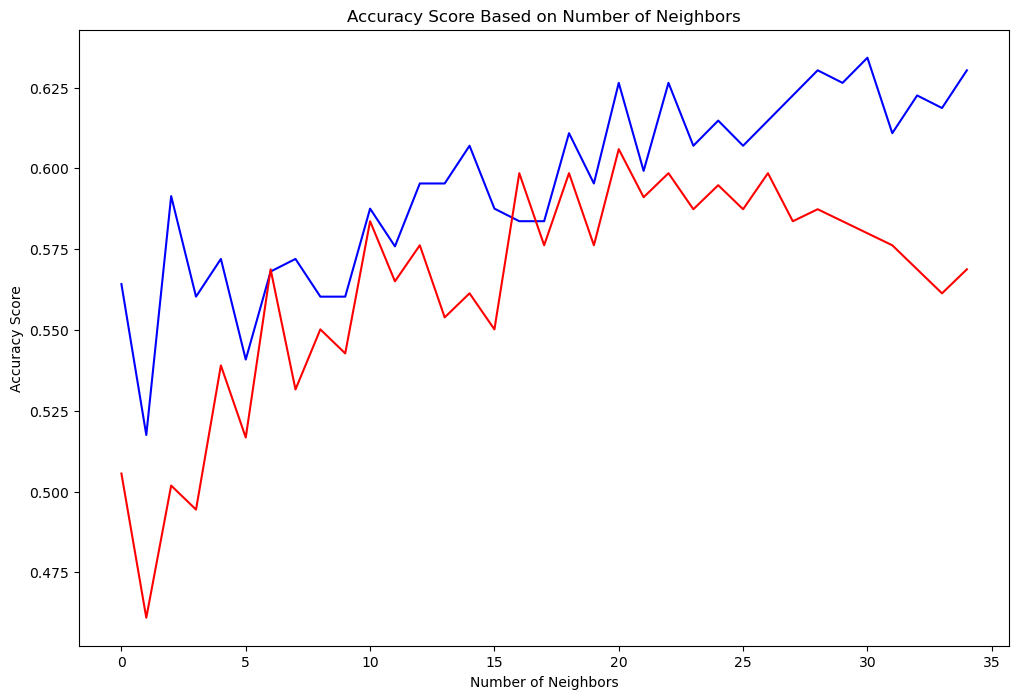

In [29]:
optimalFigure = plt.figure(figsize = (12, 8))
plt.plot(testScore, color = "blue")
plt.plot(validationScore, color = "red")
plt.ylabel("Accuracy Score")
plt.xlabel("Number of Neighbors")
plt.title("Accuracy Score Based on Number of Neighbors")
plt.savefig("AccuracyScoreNumberofNeighbors.jpeg")

In [30]:
neigh = KNeighborsClassifier(n_neighbors=21)

**Fitting and Testing The Model**  
Using the X_train and y_train data to build the model. The X_test is used to test the model performance. To evaluate the performance of the model, a classification report and a confusion matrix is created.

Testing Data Accuracy: 0.6264591439688716
              precision    recall  f1-score   support

           0       0.57      0.49      0.52       109
           1       0.66      0.73      0.69       148

    accuracy                           0.63       257
   macro avg       0.61      0.61      0.61       257
weighted avg       0.62      0.63      0.62       257



<Figure size 800x1000 with 0 Axes>

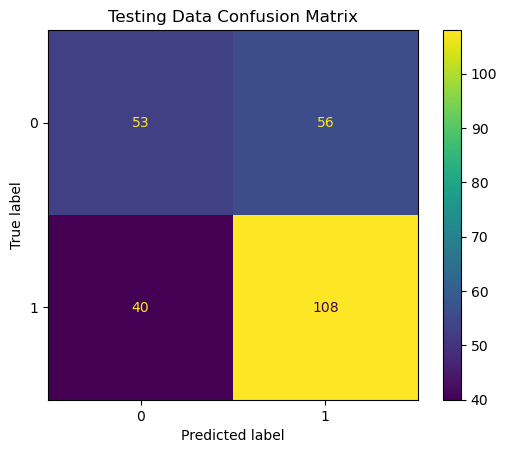

In [31]:
neigh.fit(X_train, y_train)

y_pred = neigh.predict(X_test)
print(f"Testing Data Accuracy: {neigh.score(X_test, y_test)}")
print(classification_report(y_test,y_pred))
confusionMatrix(y_test, y_pred, neigh, "Testing Data Confusion Matrix", "KNN_TestingDataConfusionMatrix.jpeg")

**Model Validation**  
Using the 2022-2023 NFL season to validate the accuracy of the model.

Validation Data Accuracy: 0.6059479553903345
              precision    recall  f1-score   support

           0       0.56      0.47      0.51       118
           1       0.63      0.72      0.67       151

    accuracy                           0.61       269
   macro avg       0.60      0.59      0.59       269
weighted avg       0.60      0.61      0.60       269



<Figure size 800x1000 with 0 Axes>

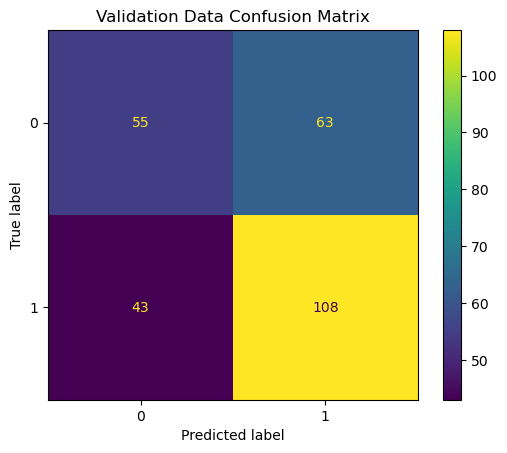

In [34]:
y_val_predictions = neigh.predict(X_validate)
print(f"Validation Data Accuracy: {neigh.score(X_validate, y_validate)}")
print(classification_report(y_validate,y_val_predictions))
confusionMatrix(y_validate, y_val_predictions, neigh, "Validation Data Confusion Matrix", "KNN_ValidationDataConfusionMatrix.jpeg")

**Model Performance**  


Looking at the testing data and validation data classification reports and confusion matrices it appears that the model is having a difficult time in accurately predicting away team victories. This is seen in the confusion matrix that there is a great number of falsely predicted away team victories. This inaccurracies in terms of away team victories lowered the accuracy scores of the model. The accuracy scores for the various number of neighbors were reguarly in the mid to upper 50% range.